In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization


from keras.optimizers import SGD, Adam
from keras import initializers
from keras import backend as K

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np

Using TensorFlow backend.


In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('poster_0.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='.', save_prefix='poster', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [89]:
num_classes = 8

input_shape = (192, 128,3)

# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape,
                 kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(BatchNormalization())
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(BatchNormalization())
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
# --- fully connected layer ---
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# --- fully connected layer ---
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# --- classification ---
model.add(Dense(8, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 188, 124, 16)      1216      
_________________________________________________________________
batch_normalization_22 (Batc (None, 188, 124, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 94, 62, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 92, 60, 64)        9280      
_________________________________________________________________
batch_normalization_23 (Batc (None, 92, 60, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 46, 30, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 88320)             0         
__________

In [103]:
learning_rate = 0.01

sgd = SGD(lr=learning_rate, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [116]:
img_batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(192, 128),  # all images will be resized to 150x150
        batch_size=img_batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(192, 128),
        batch_size=img_batch_size,
        class_mode='categorical')

Found 11862 images belonging to 8 classes.
Found 2965 images belonging to 8 classes.


In [141]:
#tensorboard = TensorBoard(log_dir='./logs/cnn/' , histogram_freq=1, write_graph=True, write_images=False)

batch_size = 128
epoch = 100
#class_weight = {0:1.0,1:1.0,2:1.0,3:2.182938620088743,4:1.0,5:1.0,6:1.0,7:1.4319240572082488}
#class_weight = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
#class_weight = {0 : 0.33, 1:0.11 , 2: 0.25, 3:1 , 4:0.2, 5:0.33, 6:0.043 , 7:.5}

history = model.fit_generator(
            train_generator,
            steps_per_epoch=batch_size // batch_size,
            epochs=epoch,
            validation_data=validation_generator,
            #class_weight = class_weight,
            validation_steps=800 // batch_size)

Epoch 1/100
1/1 [==============================] - 0s - loss: 1.7734 - acc: 0.2500 - val_loss: 1.8744 - val_acc: 0.2188
Epoch 2/100
1/1 [==============================] - 0s - loss: 1.7136 - acc: 0.3750 - val_loss: 1.9597 - val_acc: 0.3021
Epoch 3/100
1/1 [==============================] - 0s - loss: 1.8878 - acc: 0.1875 - val_loss: 1.9077 - val_acc: 0.2917
Epoch 4/100
1/1 [==============================] - 0s - loss: 1.8310 - acc: 0.3750 - val_loss: 1.6766 - val_acc: 0.4062
Epoch 5/100
1/1 [==============================] - 0s - loss: 2.0867 - acc: 0.2500 - val_loss: 1.7526 - val_acc: 0.4479
Epoch 6/100
1/1 [==============================] - 0s - loss: 1.7800 - acc: 0.4375 - val_loss: 1.8565 - val_acc: 0.4062
Epoch 7/100
1/1 [==============================] - 0s - loss: 1.9768 - acc: 0.3125 - val_loss: 1.7081 - val_acc: 0.4375
Epoch 8/100
1/1 [==============================] - 0s - loss: 2.0005 - acc: 0.1875 - val_loss: 1.6862 - val_acc: 0.3958
Epoch 9/100
1/1 [=======================

In [142]:
test_datagen = ImageDataGenerator(rescale=1./255)
# this is a similar generator, for test data
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(192, 128),
        batch_size=img_batch_size,
        class_mode='categorical')

results = model.evaluate_generator (
            test_generator,
            steps = 40,
            max_q_size=10, 
            workers=1, 
            pickle_safe=False)

print("The [loss, accuracy] of the evaluation are: " + str(results))

Found 3707 images belonging to 8 classes.
The [loss, accuracy] of the evaluation are: [1.7768651336431502, 0.421875]


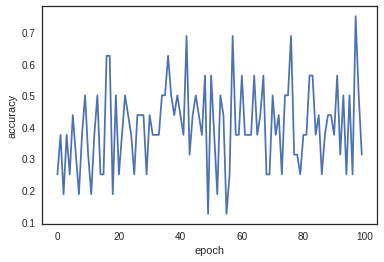

In [143]:
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [144]:
y_pred_prob = model.predict_generator(test_generator,
                                      steps = 38,
                                      verbose=1)

37/38 [============================>.] - ETA: 0s

In [145]:
y_pred_prob.shape

(608, 8)

In [146]:
# Function get classess of Non sequential model as print class function worked for sequential model onl
def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

def probas_to_classes(y_pred):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        return categorical_probas_to_classes(y_pred)
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

In [147]:
y_pred = probas_to_classes(y_pred_prob)

In [148]:
u, unique_counts  = np.unique(y_pred, return_counts=True)
print(u)
print(unique_counts)

[0 1 2 4 5 6]
[  1  57   6  66   3 475]
